### Loading in the Data and setting the index

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

securities_df = pd.read_csv('spy_tlt_gld.csv')
securities_df['Date'] = pd.to_datetime(securities_df['Date'], dayfirst=False)
securities_df.set_index('Date', inplace=True)

securities_pct = securities_df.pct_change()
securities_pct.fillna(0, inplace=True)

### Setting the inputs for the function that will calculate the allocation to SPY, TLT and GLD based on their volatility

In [90]:
lookback = 252
target_vol = 0.1
rebal_freq = 21

### Creating the function to take the percentage change DataFrame as an input and will return a DataFrame with the desired allocation

In [91]:
from math import sqrt

def calculate_allocation(df_pct, vol_period, target_vol, rebal_freq):
    
    # DataFrame which holds the rolling annualized historical volatility based on vol_period days
    security_vol = df_pct.rolling(vol_period).std() * sqrt(252)
    security_vol.dropna(inplace=True)

    # creating a DataFrame which stores the theoretical daily allocation to each asset based on the assets volatility
    # and the portfolio's target volatility
    num_stocks = len(security_vol.columns)
    allocation = target_vol / num_stocks / security_vol

    # only want to keep allocation values for every rebal_freq days, then fill forward until next rebal_freq multiple
    allocation_slice = allocation.iloc[0::rebal_freq]

    final_allocation = pd.DataFrame(data=allocation_slice, index=allocation.index)
    final_allocation.fillna(method='ffill', inplace=True)
    
    # When the portfolio calls for leverage the cash value will be negative - if cash is positive there is cash in the portfoio     
    final_allocation['Cash'] = 1 - final_allocation.sum(axis=1)

    return final_allocation

### Calling our calculate_allocation function to set the DataFrame "allocation" as our target allocation to each asset

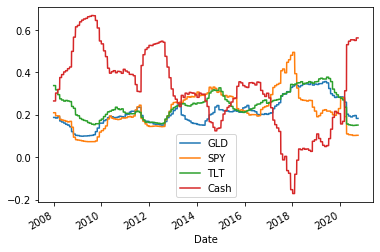

In [92]:
allocation = calculate_allocation(df_pct=securities_pct,
                                  vol_period=lookback,
                                  target_vol=target_vol,
                                  rebal_freq=rebal_freq)

allocation.plot()
plt.show()

### Removing the Daily pct_change data that's not required, this is percent change data before the allocation for each asset is determined

In [93]:
securities_pct = securities_pct.loc[allocation.index[0]:].copy()

### Creating a cash column for the percentage change DataFrame - this just means that the portion of portfolio in cash will have no day-day movements

In [94]:
securities_pct['Cash'] = 0

### Setting up the new DataFrames and inputs that will be used on the core backtest loop

In [95]:
# the initial investment
invested = 1000

# the common date index between returns, securities_pct
dates = securities_pct.index

# the securities present in the backtest
securities = securities_pct.columns

# the dollar value of the portfolio
portfolio_value = pd.DataFrame(data=None, columns=['Portfolio'], index=dates)
portfolio_value.iloc[0]['Portfolio'] = invested

# the $ value allocated in each position
positions = pd.DataFrame(data=None, columns=securities, index=dates)

# pnl_stocks will hold the net PnL Data for each stock over the entire backtest
pnl_positions = pd.DataFrame(data=0, columns=securities, index=dates)

### The Main Loop that runs the backtest

In [96]:
for t in range(0, len(securities_pct), rebal_freq):

    if t == 0:
        rb_day = dates[t]
    else:
        rb_day = dates[t + 1]

    # the day that we rebalance the portfolio, use this value in portfolio_value to calculate allocation
    rb_value = dates[t]

    try:
        rb_end = dates[t + rebal_freq]
    except IndexError:
        rb_end = dates[-1]
    
    for position in positions:
        positions.loc[rb_day: rb_end, position] = portfolio_value['Portfolio'][rb_value] * (
                allocation[position][rb_day] * np.cumprod(1 + securities_pct.loc[rb_day: rb_end, position]))

        pnl_positions.loc[rb_day:rb_end, position] = (positions.loc[rb_day:rb_end, position] -
                                                      portfolio_value['Portfolio'][rb_value] * allocation[position][
                                                          rb_day]
                                                      ) + pnl_positions.loc[rb_value, position]

    portfolio_value.loc[rb_day: rb_end, 'Portfolio'] = np.nansum(positions.loc[rb_day: rb_end], axis=1)

### Plotting the Equity Curve of the backtest

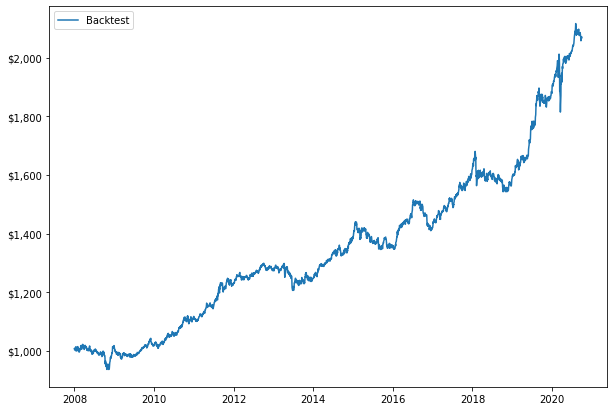

In [97]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(portfolio_value, label='Backtest')

formatter = ticker.StrMethodFormatter('${x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)

ax1.legend()

plt.show()

### Plotting the Drawdowns of the Backtest

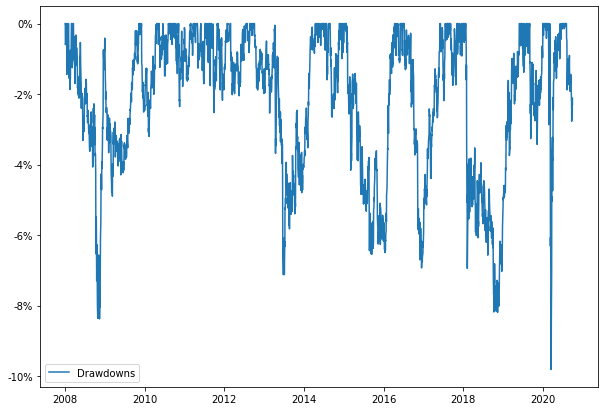

In [100]:
drawdowns = (portfolio_value['Portfolio'] / portfolio_value['Portfolio'].cummax()) - 1

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(drawdowns, label='Drawdowns')

pct_formatter = ticker.PercentFormatter(1, decimals=0)
ax1.yaxis.set_major_formatter(pct_formatter)

plt.legend()
plt.show()

### Charting the PnL of assets in the portfolio

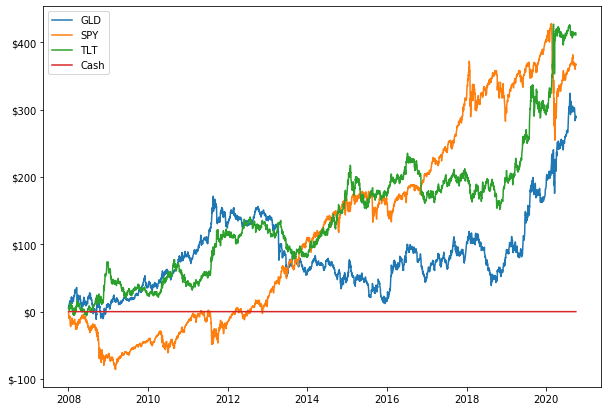

In [103]:
fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(1, 1, 1)


for position in pnl_positions:
    ax1.plot(pnl_positions[position], label=position)

formatter = ticker.StrMethodFormatter('${x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()